In [1]:
import argparse
import os, sys
import time
import copy
import math
import pickle
import statistics

import numpy as np
import pandas as pd
import open3d as o3d
import torchvision
import pytorch3d
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.utils import _single, _pair, _triple
from torchsummary import summary

from pytorch3d.loss import chamfer_distance

# Import toolkits
from utils.visualization_3D_objects import *
from utils.preprocessing import *
from utils.read_object import *
from utils.model_averaging import *
from utils.model_PCA import *
from utils.morphable_model import *
from utils.model_evaluation import *

from model.PointNetAE import PCAutoEncoder

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Import Preprocessed ModelNet40 cars

In [2]:
#load all aligned cars
DATA_PATH = "./data/processedShapeNet/car/"
f1 = open(DATA_PATH+'train.txt','rb')
X_train = pickle.load(f1)
f2 = open(DATA_PATH+'test.txt','rb')
X_test = pickle.load(f2)

In [3]:
TRAIN_BATCH_SIZE = 12
VAL_BATCH_SIZE = 10

# construct dataloader
train_loader = DataLoader(
    X_train, 
    batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
)
val_loader = DataLoader(
    X_test, 
    batch_size=VAL_BATCH_SIZE, 
    shuffle=False, 
    num_workers=4
)

### Deploy model on GPU

In [4]:
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
model = PCAutoEncoder(3, X_train[0].shape[1])
model = model.to(device)

# Check if on GPU
assert(next(model.parameters()).is_cuda)

Run on GPU...


In [5]:

# initial learning rate = 0.1, decay rate = 0.1
INITIAL_LR = 0.001

# momentum for optimizer = 0.9
MOMENTUM = 0.9

# L2 regularization strength = 0.0001
REG = 1e-4

# create loss function: Chamfer distance
criterion = lambda recon_x, x: chamfer_distance(recon_x, x)

# Add optimizer
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

### Training

In [8]:
# some hyperparameters
# total number of training epochs
EPOCHS = 20
DECAY_EPOCHS = 20
DECAY = 0.7
# DECAY = 0.1

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_loss = 1e20
current_learning_rate = INITIAL_LR

start = time.time()
print("==> Training starts!")
print("="*50)

# store loss learning curve
train_loss_lst = []
valid_loss_lst = []

for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    
    # switch to train mode
    model.train()
    
    print("Epoch %d:" %i)

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.float().to(device)

        # compute the output and loss
        outputs, _ = model(inputs)
        if (batch_idx % 120 == 0) : print(torch.mean(torch.diff(_, dim=0)))


        inputs = inputs.transpose(1, 2)
        outputs = outputs.transpose(1, 2)
        dist1, _ = criterion(outputs, inputs)

        loss = (torch.mean(dist1))
        train_loss += loss.to('cpu').detach().numpy()

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

    avg_loss = train_loss / len(train_loader)
    print("Training loss: %.4f" %(avg_loss))
    train_loss_lst.append(avg_loss)

    # switch to eval mode
    model.eval()

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want
    
    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs) in enumerate(val_loader):
            # copy inputs to device
            inputs = inputs.float().to(device)
            # compute the output and loss
            outputs, _ = model(inputs)

            inputs = inputs.transpose(1, 2)
            outputs = outputs.transpose(1, 2)

            dist1, _ = criterion(outputs, inputs)

            loss = (torch.mean(dist1))
            val_loss += loss

    avg_loss = val_loss / len(val_loader)
    print("Validation loss: %.4f" % (avg_loss))
    
    valid_loss_lst.append(avg_loss.cpu().detach().numpy())
    
    # save the model checkpoint
    if avg_loss < best_loss:
        best_loss = avg_loss
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'PointNetAE_normalized_input.pth'))
        
    print('')

print("="*50)
print(f"==> Optimization finished in {time.time() - start:.2f}s! Best validation accuracy: {best_loss:.4f}")

==> Training starts!
Epoch 0:
tensor(-0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 187.4532
Validation loss: 60.2352
Saving ...

Epoch 1:
tensor(-0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 58.8367
Validation loss: 61.1987

Epoch 2:
tensor(-0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0073, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 58.2797
Validation loss: 58.0697
Saving ...

Epoch 3:
tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 57.1854
Validation loss: 58.4464

Epoch 4:
tensor(0.0036, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0041, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 56.9095
Validation loss: 56.9654
Saving ...

Epoch 5:
tensor(-0.0057, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.10

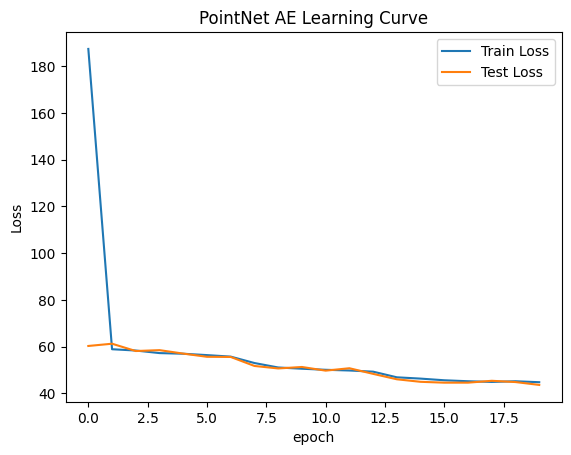

In [9]:
plt.plot(train_loss_lst, label='Train Loss')
plt.plot(valid_loss_lst, label='Test Loss')
plt.title("PointNet AE Learning Curve")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

### Examine Results

In [10]:
#load all aligned cars
DATA_PATH = "./data/processedShapeNet/car/"
f1 = open(DATA_PATH+'train.txt','rb')
X_train = pickle.load(f1)
f2 = open(DATA_PATH+'test.txt','rb')
X_test = pickle.load(f2)

In [11]:
TRAIN_BATCH_SIZE = 12
VAL_BATCH_SIZE = 10

# construct dataloader
train_loader = DataLoader(
    X_train, 
    batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
)
val_loader = DataLoader(
    X_test, 
    batch_size=VAL_BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
    
model_test = PCAutoEncoder(3, 2048)
state_dict = torch.load('./saved_model/PointNetAE_normalized_input.pth') # change the path to your own checkpoint file
model_test.cuda()
model_test.load_state_dict(state_dict['state_dict'])
model_test.eval()

print(state_dict['epoch'])

Run on GPU...
19


In [13]:
x_train = train_loader.__iter__().next() # hack to grab a batch
x_val = val_loader.__iter__().next() # hack to grab a batch
# model = PCAutoEncoder(3, 2048).to(device)
inputs_train = x_train.float().to(device)
outputs_train, _ = model_test(inputs_train)
print(_.shape)
print(torch.mean(torch.diff(_, dim=0)))
print(_)
X_train = inputs_train.cpu().detach().numpy()[0]
X_hat_train = outputs_train.cpu().detach().numpy()[0]

inputs_val = x_val.float().to(device)
outputs_val, _ = model_test(inputs_val)
print(_)
X_val = inputs_val.cpu().detach().numpy()[0]
X_hat_val = outputs_val.cpu().detach().numpy()[0]

print(outputs_train.shape)
chamfer_distance(outputs_val.transpose(2,1)[:10], outputs_train.transpose(2,1)[:10])


torch.Size([12, 1024])
tensor(-0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[0.3287, 0.3890, 1.1507,  ..., 0.0000, 0.3036, 0.4449],
        [0.3834, 0.4868, 1.2926,  ..., 0.0000, 0.4117, 0.4173],
        [0.4141, 0.4475, 1.2876,  ..., 0.0000, 0.3609, 0.4043],
        ...,
        [0.3646, 0.3877, 1.2643,  ..., 0.0000, 0.3676, 0.4312],
        [0.4095, 0.4893, 1.2444,  ..., 0.0000, 0.3813, 0.4092],
        [0.3804, 0.4947, 1.2070,  ..., 0.0000, 0.3744, 0.4390]],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor([[0.3157, 0.3886, 1.2964,  ..., 0.0000, 0.3373, 0.3959],
        [0.2996, 0.3890, 1.2033,  ..., 0.0000, 0.3355, 0.3361],
        [0.3023, 0.3905, 1.0906,  ..., 0.0000, 0.3485, 0.3780],
        ...,
        [0.3199, 0.3739, 1.1509,  ..., 0.0000, 0.3506, 0.4038],
        [0.4011, 0.4435, 1.2159,  ..., 0.0000, 0.4194, 0.3941],
        [0.3794, 0.3931, 1.3605,  ..., 0.0000, 0.3258, 0.4121]],
       device='cuda:0', grad_fn=<ViewBackward>)
torch.Size([12, 3, 2048])


(tensor(38.4250, device='cuda:0', grad_fn=<AddBackward0>), None)

In [15]:
x = val_loader.__iter__().next() # hack to grab a batch

inputs = x.float().to(device)

# outputs, t3, t64 = model(inputs)
outputs, _ = model_test(inputs)

dist, _ = criterion(outputs.transpose(1, 2), inputs.transpose(1, 2))

print(torch.mean(dist), dist)

# X_trans = torch.einsum('bij,bjk->bik', t3, inputs).cpu().detach().numpy()[0]
X = inputs.cpu().detach().numpy()[1]
X_hat = outputs.cpu().detach().numpy()[1]

draw3DPoints(X)
# draw3DPoints(X_trans)
draw3DPoints(X_hat)

tensor(46.6002, device='cuda:0', grad_fn=<MeanBackward0>) tensor(46.6002, device='cuda:0', grad_fn=<AddBackward0>)
